In [2]:
import sys
# Add the ptdraft folder path to the sys.path list
sys.path.append('../src/')

import data_config as dc
wormData = dc.kato.data()


In [3]:

# I hate the list comprehensions too. When we start doing serious analysis this wont happen
nname_to_index = [{wormData[i]['NeuronIds'][0][j]:j
                   for j in range(len(wormData[i]['NeuronIds'][0])) 
                   if wormData[i]['NeuronIds'][0][j]!=None}
                  for i in range(5)]

neurons = [ set(filter(lambda x: x!=None, wormData[i]['NeuronIds'][0].values)) for i in range(5) ]
all_shared_neurons = set.intersection(*neurons)

# Let's compute shared neurons in the dataset
from itertools import combinations
groupings  = [ i for i in combinations(range(5), r=2)]
similars = {}
for i,j in groupings: 
    ns_i = neurons[i]
    ns_j = neurons[j] 
    similars[(i,j)] = similars[(j,i)] = set.intersection(set(ns_i), set(ns_j))

for i in range(5):
    groupings.append((i,i))
    similars[(i,i)] = set.intersection(set(neurons[i]), set(neurons[i]))
    

Now let's build a data structure so we can compare across datasets: we'll use Kato's first assumed neuron names and only later will handle the nuanced case of working with both hypotheses. 

In [4]:
import numpy as np

def crosscorrelate(a,b):
  return np.dot(a, b.T)

def global_similars(i,j):
    """
    Returns a two-tuple containing the indexes in datasets i and j 
    respectively of the neurons shared amongst the entire dataset. 
    """
    neurons = all_shared_neurons
    indexes_a = [v for k,v in nname_to_index[i].iteritems() if k in neurons]
    indexes_b = [v for k,v in nname_to_index[j].iteritems() if k in neurons]
    return sorted(indexes_a), sorted(indexes_b)


def local_similars(i,j):
    """
    Returns a two-tuple containing the indexes in datasets i and j 
    respectively of the neurons shared amongst datasets i and j. 
    """
    neurons = similars[(i,j)]
    indexes_a = [v for k,v in nname_to_index[i].iteritems() if k in neurons]
    indexes_b = [v for k,v in nname_to_index[j].iteritems() if k in neurons]
    return sorted(indexes_a), sorted(indexes_b)

def assemble_shared(i,j, dataset_name, indi, indj, ):
    """
    Returns a two-tuple containing time series for the neurons at the indexes
    indi and indj in the i and jth dataset respectively. 
    """
    matrix_i = np.take(wormData[i][dataset_name], indi,axis=0)
    matrix_j = np.take(wormData[j][dataset_name], indj,axis=0)
    return matrix_i, matrix_j

def prune(a,b):
    """
    Prunes off indexes from the larger dataset so they have equal dimensions. 
    Only works for 1D arrays for now. 
    """
    last = min(a.shape[1], b.shape[1])
    # YES - the is no interpolation for wholly unknown data
    # Interpolation iff Parameterized model, both of which are false
    # http://stats.stackexchange.com/questions/3589/correlation-between-two-variables-of-unequal-size
    return (a[:,0:last], b[:,0:last])
    
def correlator_data_gen(i,j, dataset_name, fetch_shared_ns):
    # We need to prune off the end of the larger dataset so they 
    # both are of the same length to make cross correlation possible
    matri, matrj = prune(
        # Assemble the datasets for neurons shared 
        *assemble_shared(i,j, 
            dataset_name,
            # Fetch shared neurons using abstract metric function
            *fetch_shared_ns(i,j)
        
    )) 
    
    return matri, matrj
    
    
  


Now we can plot

[(1, 3), (3, 0), (2, 1), (0, 3), (4, 0), (1, 2), (3, 3), (4, 4), (0, 4), (4, 1), (1, 1), (3, 2), (0, 0), (2, 2), (1, 4), (2, 3), (4, 2), (1, 0), (0, 1), (3, 1), (0, 2), (2, 0), (4, 3), (3, 4), (2, 4)]
(30, 3021)


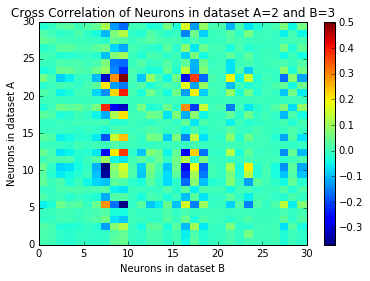

In [5]:
print similars.keys()
a,b = correlator_data_gen(2,3, 'deltaFOverF_deriv',local_similars)

print a.shape

%matplotlib inline
import matplotlib.pyplot as plt
cc = crosscorrelate(a,b)
plt.pcolormesh(cc)   
plt.colorbar()
plt.title('Cross Correlation of Neurons in dataset A=2 and B=3')
plt.ylabel('Neurons in dataset A')
plt.xlabel('Neurons in dataset B')




15
15


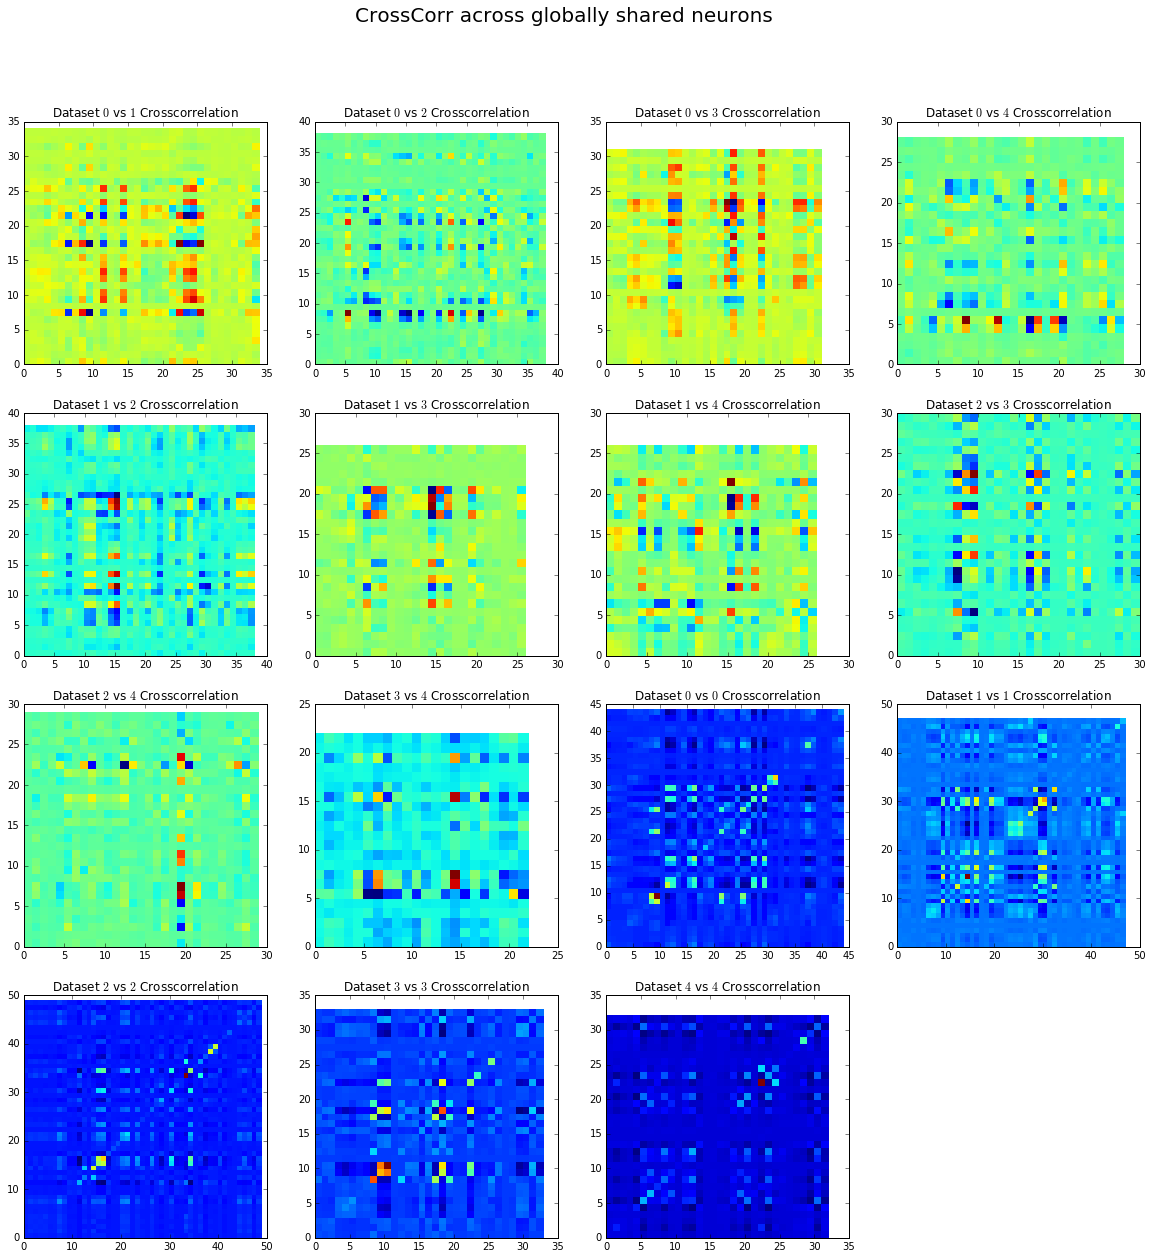

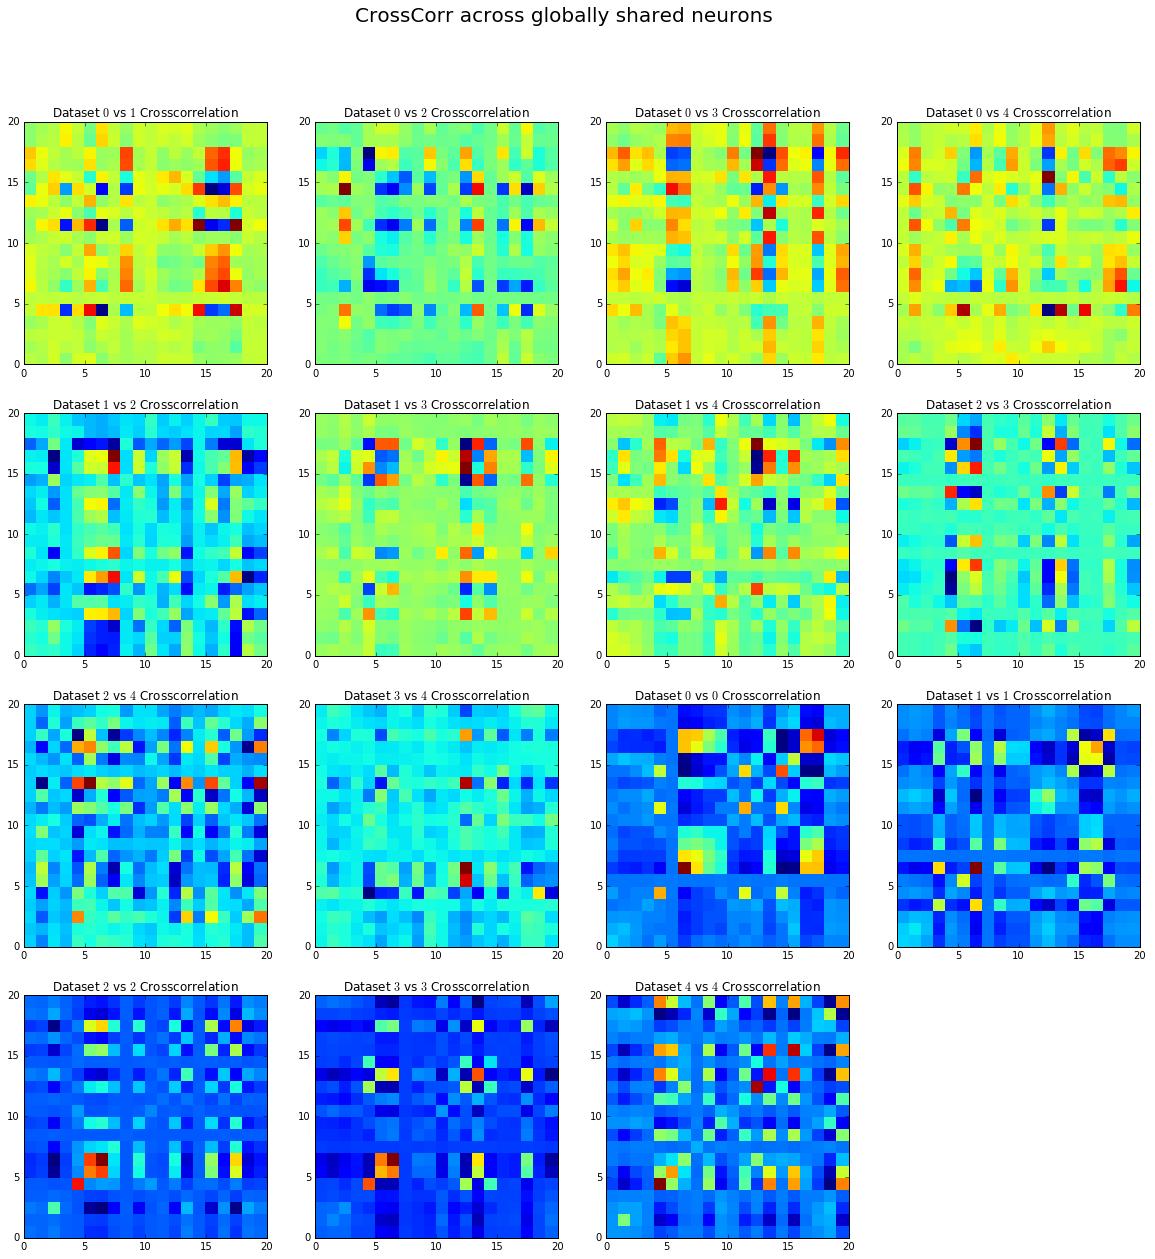

In [6]:
import dimensions_kit as dk
dimensions=(4,4)
def plot_crosscorrelations(title, dataset, similarity_preference):
    print len(groupings)
    f, axes = plt.subplots(4,4,figsize=(20,20))

    f.suptitle(title, fontsize=20)
    n=0
    for k,i in groupings:

        x,y = dk.transform((4,4),n)

        axis = axes[x][y]
        a,b = correlator_data_gen(k,i,dataset,similarity_preference)
        axis.pcolormesh(crosscorrelate(a,b))

        axis.set_title('Dataset ${0}$ vs ${1}$ Crosscorrelation'.format(k,i))
     
        n+=1

    while n < dimensions[0]*dimensions[1]:
        x,y = dk.transform(dimensions,n)
        axes[x][y].axis('off')
        n+=1
        
plot_crosscorrelations('CrossCorr across globally shared neurons', 
    'deltaFOverF_deriv', local_similars)

plot_crosscorrelations('CrossCorr across globally shared neurons', 
    'deltaFOverF_deriv', global_similars)

Cross correlations are essentially linear convolutions - i.e. linear combinations of two functions, though here we didn't do a delay. 


### Clustering
*do we need to subtract time derivatives from the data to do a "sliding window" cross correlation?*
If you look at the images above, you'll notice even though cross correlation should describe causal relationships between signals, the causal relationships are fairly inconsistent amond the datasets visually, though there are some boxlike regions. **Once you cluster, things might become clearer.** 

Covariance and Cross Correlation are both linear combinations of two signals. Just like with PCA, a lot of the nonlinear information is lost (**would be interesting to quantify precisely how much information is lost**). So after doing some research, I discovered this: https://www.researchgate.net/post/how_can_I_find_the_cross-correlation_between_two_time_series_atmospheric_data – we should look for [partial] mututal information. 

### Taking Advantage of the Datasets
Though I haven't studied fourier transforms in depth, it'd be interesting to take a quantitative look on how information travels through neural networks by jumping onto a forward signal and then being taken off the signal by some downstream neuron: here is a good tutorial on FTs: http://www.di.fc.ul.pt/~jpn/r/fourier/fourier.html. 

### Extending this
After running our cross correlation, there are a few ideas that come to mind: 

- General clustering of neurons in all these measures: cross correlation, PCA, etc. Clustering for different properties
- Functional clustering algorithm
- **Developing new algorithm to take connectivity into account**
- Developing new metrics for more detailed information flow/computational functions of neurons and starting out with plotting them
- Running monte carlo simulations on the different computational building blocks – (this is an idea I've had for a while) and then look for these dynamic patterns in our dynamic data. 
- Monte Carlo neuron annealing based on some heuristic and predicting what will happen with bayesian inference. 
- Using Machine learning to learn nonlinear parameter metrics and which directions go downwards to parameterize C Elegans. 
- Particle swarm optimization: https://en.wikipedia.org/wiki/Particle_swarm_optimization
- Percolation theory

There are many different perspectives on the data – the important thing is getting true insight and not running different procedures for their own sake. 

One interesting algorithm, which motivated this notebook in the first place, was Sarah Feldt's FCA paper. It is a different perspective on the same data that Kato used. The difference here is we aren't looking at global patterns, but at information flow through functional structure. Nevertheless, what scares me is all these techniques use linear metrics yet the data is **highly nonlinear**. The linear metrics do give a good linear approximation and I'm not sure what the error would be if the metrics weren't linear, but I'm wondering how we can become more exact. 

### Fourier Transforms

Just to feel like I've really gotten into numerical analysis, I'm going to run a standard FFT on my time series. I'm doing this without deeply understanding the algorithm because *first experiment* then *understand*. Or after the biblical maxim *aharei hapiulot nimshehet halevavot*.

Here's what numpy says about fourier analysis: 

> Fourier analysis is fundamentally a method for expressing a function as a sum of periodic components, and for recovering the function from those components. When both the function and its Fourier transform are replaced with discretized counterparts, it is called the discrete Fourier transform (DFT). The DFT has become a mainstay of numerical computing in part because of a very fast algorithm for computing it, called the Fast Fourier Transform (FFT), which was known to Gauss (1805) and was brought to light in its current form by Cooley and Tukey [CT]. Press et al. [NR] provide an accessible introduction to Fourier analysis and its applications.

We are really doing to use the discrete version (DFT) using *difference equations* somewhre (thanks Knuth and Concrete Mathematics) but the ideas are the same.

$A_k=\sum_{m=0}^{n-1}a_m\exp\begin{Bmatrix}-2\pi i\frac{mk}{n}\end{Bmatrix}\ k=0,...,n-1$

If you'll notice this is really the sover every point. The discrete version would be an integral. 

If you've encountered Euler's formula before you'll understand this equation. We know from Euler (and the proof is with Taylor expansions of $sin(x)$ and $cos(x)$ that $e^{ix}=cos(x)+isin(x)$. Without full expertise in the math-theoretic details, I know the left side of the equation yields oscillatory behavior from the special case of Euler's formula $e^{i\pi}=-1$. Taking the square root of both sides yields i: $e^{i\frac{\pi}{2}}=i$, which we know when raised to the $x^{th}$ power os oscillatory. Hence $\exp\begin{Bmatrix}^{ix\frac{\pi}{2}}\end{Bmatrix}$ is oscillatory (thanks to Dov Greenwood for explaining to me this morning what Taylor series are and how they can be used to prove Euler's formula; the brilliance isn't the proof at all. It's the mind which made the observation)

Adding up the different waves is the basis of fourier transforms, a really beautiful topic in pure and numerical maths. 

So let's start fouriering

NameError: name 'sp' is not defined

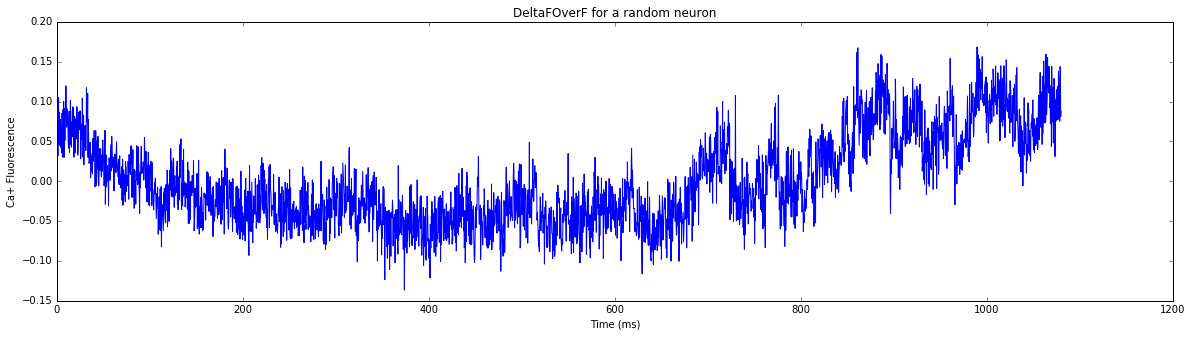

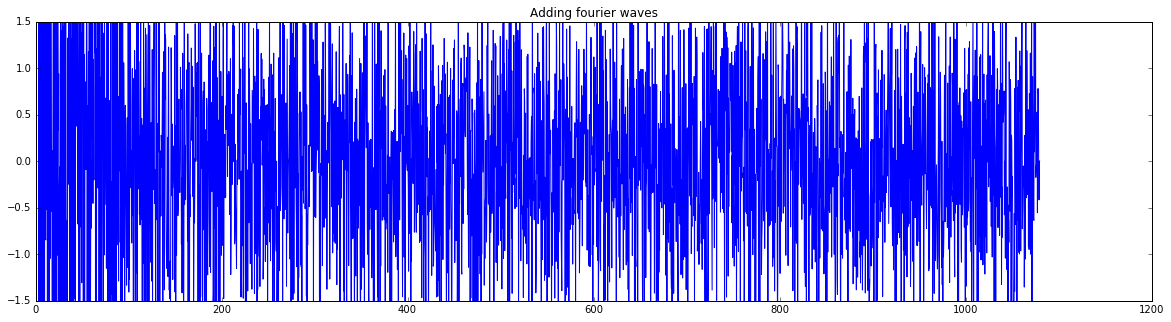

In [7]:
#lets do this ft thinga majing
import scipy.fftpack

timeseries = wormData[0]['deltaFOverF'][34]
x = wormData[0]['tv'][0]

N=x.shape[0]

plt.figure(figsize=(20,5))
plt.title('DeltaFOverF for a random neuron')
plt.ylabel('Ca+ Fluorescence')
plt.xlabel('Time (ms)')
plt.plot(x,timeseries)


w = scipy.fftpack.rfft(timeseries)
f = scipy.fftpack.rfftfreq(N, x[1]-x[0])
spectrum = w**2

y2 = scipy.fftpack.irfft(w)

plt.figure(figsize=(20,5))
plt.title('Adding fourier waves')
plt.ylim((-1.5,1.5))
plt.plot(x,w)
print sp.imag.shape



As was evident, I do not fully understand Fouriers, but now have a better untuition for what they do. So I'll need to go read about fouriers. 